# Import all packages

In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
using Turing
using MCMCChains
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using OrdinaryDiffEq
Random.seed!(145975);
using CmdStan
using KernelDensity
using LaTeXStrings
using StatsBase
using JLD2
using BlackBoxOptim
using BlackBoxOptim: num_func_evals
using HypothesisTests
using BayesianOptimization, GaussianProcesses

set_cmdstan_home!("C:\\cmdstan\\cmdstan-2.30.0");

┌ Warning: Environment variable CMDSTAN_HOME not set. Use set_cmdstan_home!.
└ @ CmdStan C:\Users\dgomez\.julia\packages\CmdStan\2vwWj\src\CmdStan.jl:27


In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\FunctionsBayesInfs.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\FunctionsBayesOED.jl")

redSamples (generic function with 2 methods)

# Define True Theta and Posterior

In [3]:
trueP_CR = [48.0, 55.0, 0.005911, 0.01832, 0.042171, 0.5365, 0.98047, 0.991257, 0.93335, 0.008241, 0.9943848, 0.001974,   15];
InitsY0_CR = [450, 12599, 226];

trueP_AL = [48.0, 55.0, 0.0071, 0.075, 0.0397, 0.005999, 0.00039, 0.7968, 0.000194, 0.08797, 0.0002692, 0.06151, 15];
InitsY0_AL = [7.36];

In [4]:
NSamps = 1000;

In [5]:
priorTheta_CR = Array{Any}(undef, 13);
priotY0_CR = Array{Any}(undef, 3);


priorTheta_CR[1] = Normal(48, 1); 
priorTheta_CR[2] = Normal(55, 1); 
priorTheta_CR[3] = Truncated(Normal(0.005911, 0.005911*0.05), 0,2); 
priorTheta_CR[4] = Truncated(Normal(0.01832, 0.01832*0.05), 0,2); 
priorTheta_CR[5] = Truncated(Normal(0.042171, 0.042171*0.05), 0,2); 
priorTheta_CR[6] = Truncated(Normal(0.5365, 0.5365*0.05), 0,2); 
priorTheta_CR[7] = Truncated(Normal(0.98047, 0.98047*0.05), 0,2); 
priorTheta_CR[8] = Truncated(Normal(0.991257, 0.991257*0.05), 0,2); 
priorTheta_CR[9] = Truncated(Normal(0.93335, 0.93335*0.05), 0,2); 
priorTheta_CR[10] = Truncated(Normal(0.008241, 0.008241*0.05), 0,2);
priorTheta_CR[11] = Truncated(Normal(0.9943848, 0.9943848*0.05), 0,2); 
priorTheta_CR[12] = Truncated(Normal(0.001974, 0.001974*0.05), 0,2); 
priorTheta_CR[13] = Normal(15, 1);

priotY0_CR[1] = Truncated(Normal(450, 450*0.01), 0, 1600); 
priotY0_CR[2] = Truncated(Normal(12599, 12599*0.01), 0, 4e4); 
priotY0_CR[3] = Truncated(Normal(226, 226*0.01), 0, 1600);

global sampsTh_CR = zeros(NSamps, 13);
global sampsY0_CR = zeros(NSamps, 3);

Random.seed!(687865443); 

for i in 1:13
    sampsTh_CR[:,i] = rand(priorTheta_CR[i], NSamps);
end
for i in 1:3
    sampsY0_CR[:,i] = rand(priotY0_CR[i], NSamps);
end


In [6]:
priorTheta_AL = Array{Any}(undef, 13);
priotY0_AL = Array{Any}(undef, 1);

priorTheta_AL[1] = Normal(48, 1); 
priorTheta_AL[2] = Normal(55, 1); 
priorTheta_AL[3] = Truncated(Normal(0.0071, 0.0071*0.05), 0,2); 
priorTheta_AL[4] = Truncated(Normal(0.075, 0.075*0.05), 0,2); 
priorTheta_AL[5] = Truncated(Normal(0.0397, 0.0397*0.05), 0,2); 
priorTheta_AL[6] = Truncated(Normal(0.005999, 0.005999*0.05), 0,2); 
priorTheta_AL[7] = Truncated(Normal(0.00039, 0.00039*0.05), 0,2); 
priorTheta_AL[8] = Truncated(Normal(0.7968, 0.7968*0.05), 0,2); 
priorTheta_AL[9] = Truncated(Normal(0.000194, 0.000194*0.05), 0,2); 
priorTheta_AL[10] = Truncated(Normal(0.08797, 0.08797*0.05), 0,2);
priorTheta_AL[11] = Truncated(Normal(0.0002692, 0.0002692*0.05), 0,2); 
priorTheta_AL[12] = Truncated(Normal(0.06151, 0.06151*0.05), 0,2); 
priorTheta_AL[13] = Normal(15, 1);

priotY0_AL[1] = Truncated(Normal(7.36, 7.36*0.01), 0, 1600); 


global sampsTh_AL = zeros(NSamps, 13);
global sampsY0_AL = zeros(NSamps, 3);

Random.seed!(687865443); 

for i in 1:13
    sampsTh_AL[:,i] = rand(priorTheta_AL[i], NSamps);
end
for i in 1:1
    sampsY0_AL[:,i] = rand(priotY0_AL[i], NSamps);
end


In [7]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global tsC2 = dat32mM[:,1]
global ts = 0:tsC2[end];
global samps = convert.(Int, tsC2);

# Manual Substrate/Product Curves
This only considers maximum lactate production (peak), not dynamics. 

In [12]:
Pyrs = collect(0.1:0.1:40);

In [55]:


MultiSims_CR = Array{Any}(undef, length(Pyrs));
MultiSims_AL = Array{Any}(undef, length(Pyrs));

for j in 1:length(Pyrs)
    Pyr = round(Pyrs[j], digits = 1)*1000;
    smps = size(sampsTh_CR)[1]
    # Simulate the models for each theta and Y0 sampled
    # Competitivve Repression
    SimulsAll_CR = Array{Any}(undef, smps, 3);
    for i in 1:smps
        ivss = [Pyr, 0, 0, sampsY0_CR[i,1], sampsY0_CR[i,2], sampsY0_CR[i,3], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_CR[1,end]*0.12)];
        SimulsAll_CR[i,1], SimulsAll_CR[i,2], SimulsAll_CR[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(sampsTh_CR[i,:], 0), ivss, samps);
    end

    SimulsAll_AL = Array{Any}(undef, smps, 3);
    for i in 1:smps
        ivss = [Pyr, 0, 0, sampsY0_AL[i,1], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_AL[1,end]*0.12)];
        SimulsAll_AL[i,1], SimulsAll_AL[i,2], SimulsAll_AL[i,3]  = PyruvateHP_NMR_SolveAllAl(ts, vcat(sampsTh_AL[i,:], 0), ivss, samps);
    end

    MultiSims_CR[j] = SimulsAll_CR;
    MultiSims_AL[j] = SimulsAll_AL;

end

# Takes about 2 hours

In [56]:
JLD2.save("SimulationsMultiMS.jld", "MultiSims_CR", MultiSims_CR, "MultiSims_AL", MultiSims_AL)

In [9]:
alldat = JLD2.load("SimulationsMultiMS.jld")

Dict{String, Any} with 2 entries:
  "MultiSims_AL" => Any[Any[[100.0 0.0 … 0.0 188.46; 89.3971 3.54257 … 7.85237 …
  "MultiSims_CR" => Any[Any[[100.0 0.0 … 0.0 188.46; 91.0909 0.146127 … 1.47132…

In [10]:
MultiSims_AL = alldat["MultiSims_AL"];
MultiSims_CR = alldat["MultiSims_CR"];

In [13]:
repCurv_CR = zeros(length(Pyrs), 2)
repCurv_AL = zeros(length(Pyrs), 2)

for i in 1:length(Pyrs)

    tmp_sims = zeros(NSamps, 78)
    tmp_sims2 = zeros(NSamps, 78)

    for j in 1:NSamps

        tmp_sims[j,:] = MultiSims_CR[i][:,1][j][:,11,1];
        tmp_sims2[j,:] = MultiSims_AL[i][:,1][j][:,9,1];

    end

    repCurv_CR[i, 1] = maximum(mean(tmp_sims, dims = 1));
    indma = findfirst(transpose(maximum(mean(tmp_sims, dims = 1)) .== mean(tmp_sims, dims = 1)))[1];
    repCurv_CR[i, 2] = std(tmp_sims, dims = 1)[indma];

    repCurv_AL[i, 1] = maximum(mean(tmp_sims2, dims = 1));
    indma = findfirst(transpose(maximum(mean(tmp_sims2, dims = 1)) .== mean(tmp_sims2, dims = 1)))[1];
    repCurv_AL[i, 2] = std(tmp_sims2, dims = 1)[indma];
end


In [14]:
inddis = findfirst(maximum(abs.(repCurv_CR[:,1]-repCurv_AL[:,1])).==abs.(repCurv_CR[:,1]-repCurv_AL[:,1]));

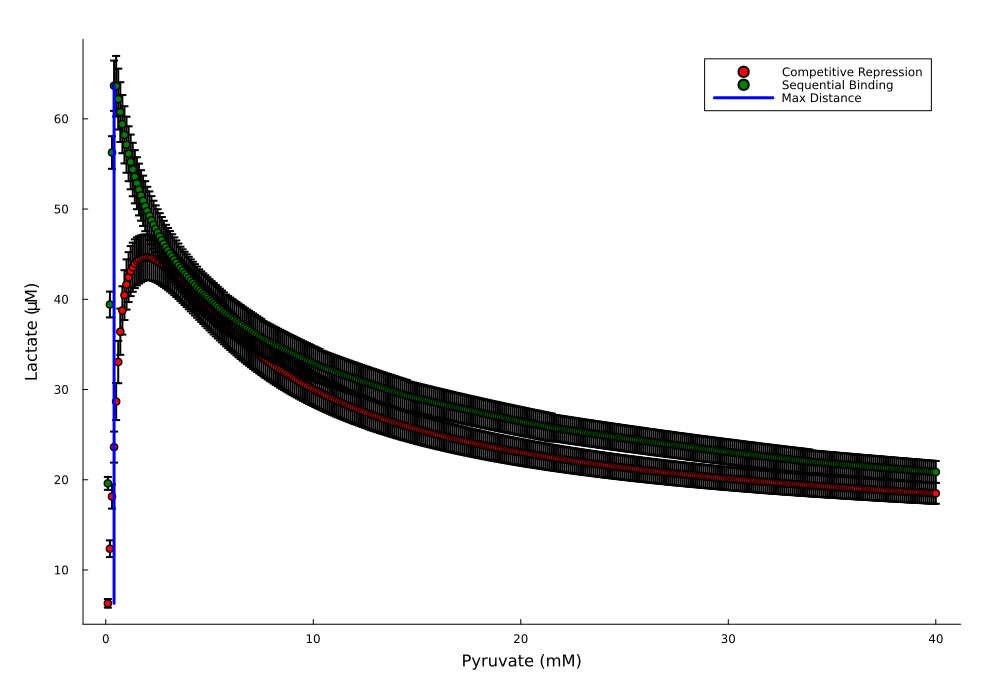

In [15]:
scatter(Pyrs, repCurv_CR[:,1], yerror = repCurv_CR[:,2], label = "Competitive Repression", grid=false, linewidth = 2, size = (1000,700), color = "red", 
        xlabel = "Pyruvate (mM)", ylabel = raw"Lactate (\muM)", margin = 8mm)
scatter!(Pyrs, repCurv_AL[:,1], yerror = repCurv_AL[:,2], label = "Sequential Binding", grid=false, linewidth = 2, size = (1000,700), color = "green")

plot!([Pyrs[inddis], Pyrs[inddis]],[minimum(vcat(repCurv_CR[:,1], repCurv_AL[:,1])), maximum(vcat(repCurv_CR[:,1], repCurv_AL[:,1]))], label = "Max Distance", linewidth=3, color = "blue")

## Plot Experiment

In [16]:
tmp_sims = zeros(NSamps, 78)
tmp_sims2 = zeros(NSamps, 78)

for j in 1:NSamps
    tmp_sims[j,:] = MultiSims_CR[inddis][:,1][j][:,11,1];
    tmp_sims2[j,:] = MultiSims_AL[inddis][:,1][j][:,9,1];
end

In [17]:
# Dims = Up/Down, Observable, Experiment
PriorQuant1 = Array{Any}(undef,2,1,1);
PriorQuant2 = Array{Any}(undef,2,1,1);

for k in 1:1
    for m in 1:1
        PriorQuant1[1,k,m] = [percentile(tmp_sims[:,j], 99.5) for j in 1:size(tmp_sims)[2]]; # Up
        PriorQuant1[2,k,m] = [percentile(tmp_sims[:,j], 0.5 ) for j in 1:size(tmp_sims)[2]]; # Down

        PriorQuant2[1,k,m] = [percentile(tmp_sims2[:,j], 99.5) for j in 1:size(tmp_sims2)[2]]; # Up
        PriorQuant2[2,k,m] = [percentile(tmp_sims2[:,j], 0.5 ) for j in 1:size(tmp_sims2)[2]]; # Down
    end
end

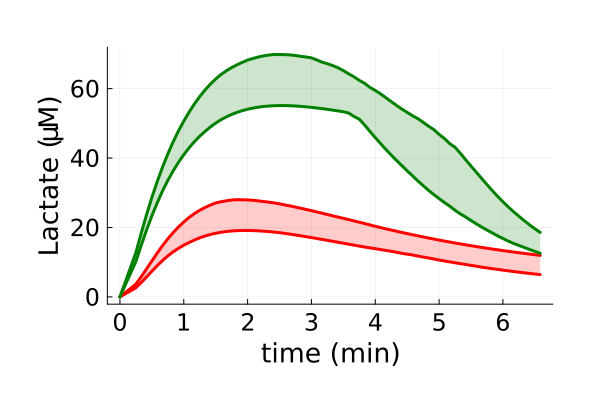

In [18]:
pr = plot(tsC2./60, PriorQuant1[1], label = "", color = "red", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant1[2], label = "", color = "red", linewidth = 3)
  plot!(tsC2./60, PriorQuant1[1], fillrange=PriorQuant1[2], label="", color="red", fillalpha=0.2)


  plot!(tsC2./60, PriorQuant2[1], label = "", color = "green", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant2[2], label = "", color = "green", linewidth = 3)
  plot!(tsC2./60, PriorQuant2[1], fillrange=PriorQuant2[2], label="", color="green", fillalpha=0.2)



In [20]:
Pyrs[inddis]

0.4

## Bhattacharyya Distances

In [36]:
bd = zeros(length(Pyrs));
for i in 1:length(Pyrs)

    tmp_sims = zeros(NSamps, 78)
    tmp_sims2 = zeros(NSamps, 78)

    for j in 1:NSamps
        tmp_sims[j,:] = MultiSims_CR[i][:,1][j][:,11,1];
        tmp_sims2[j,:] = MultiSims_AL[i][:,1][j][:,9,1];
    end


    muCR = mean!(ones(length(samps)-1), transpose(tmp_sims[:,2:end]));
    sdCR = cov((tmp_sims[:,2:end])).+0.1*Matrix((Diagonal(ones(length(samps)-1))));

    muAL = mean!(ones(length(samps)-1), transpose(tmp_sims2[:,2:end]));
    sdAL = cov((tmp_sims2[:,2:end])).+0.1*Matrix((Diagonal(ones(length(samps)-1))));

    bd[i] = -BhattacharyyaDist(muCR, muAL, sdCR, sdAL)
end


In [53]:
inddis = findfirst(minimum(bd) .== bd)

5

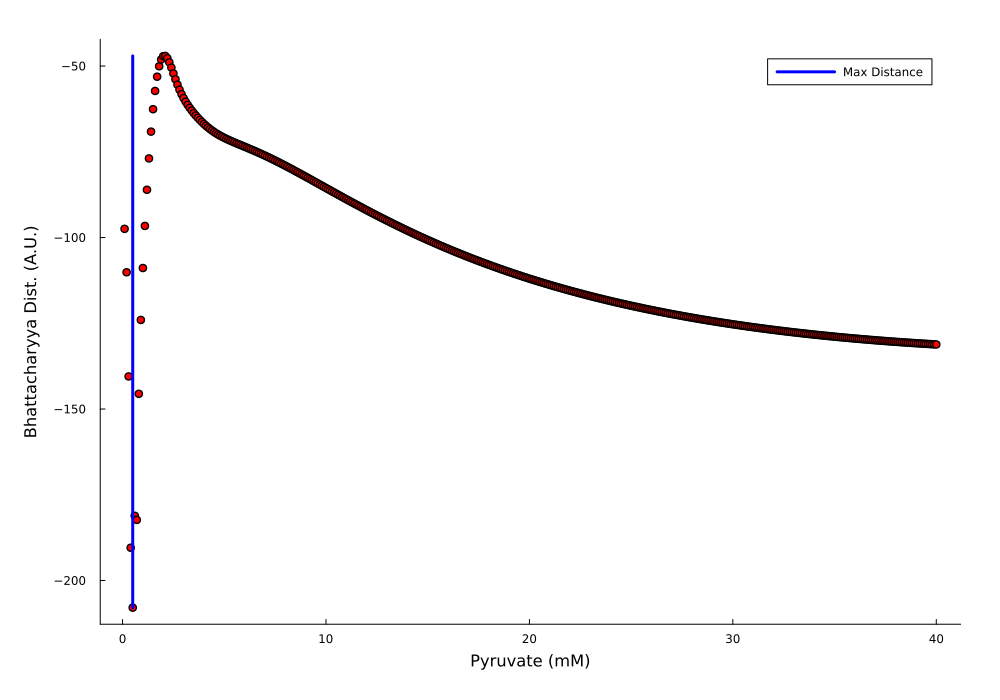

In [55]:
scatter(Pyrs, bd, label = "", grid=false, linewidth = 2, size = (1000,700), color = "red", 
        xlabel = "Pyruvate (mM)", ylabel = "Bhattacharyya Dist. (A.U.)", margin = 8mm)

plot!([Pyrs[findfirst(minimum(bd) .== bd)], Pyrs[findfirst(minimum(bd) .== bd)]],[minimum(bd), maximum(bd)], label = "Max Distance", linewidth=3, color = "blue")

## Plot Experiment

In [56]:
tmp_sims = zeros(NSamps, 78)
tmp_sims2 = zeros(NSamps, 78)

for j in 1:NSamps
    tmp_sims[j,:] = MultiSims_CR[inddis][:,1][j][:,11,1];
    tmp_sims2[j,:] = MultiSims_AL[inddis][:,1][j][:,9,1];
end

In [57]:
# Dims = Up/Down, Observable, Experiment
PriorQuant1 = Array{Any}(undef,2,1,1);
PriorQuant2 = Array{Any}(undef,2,1,1);

for k in 1:1
    for m in 1:1
        PriorQuant1[1,k,m] = [percentile(tmp_sims[:,j], 99.5) for j in 1:size(tmp_sims)[2]]; # Up
        PriorQuant1[2,k,m] = [percentile(tmp_sims[:,j], 0.5 ) for j in 1:size(tmp_sims)[2]]; # Down

        PriorQuant2[1,k,m] = [percentile(tmp_sims2[:,j], 99.5) for j in 1:size(tmp_sims2)[2]]; # Up
        PriorQuant2[2,k,m] = [percentile(tmp_sims2[:,j], 0.5 ) for j in 1:size(tmp_sims2)[2]]; # Down
    end
end

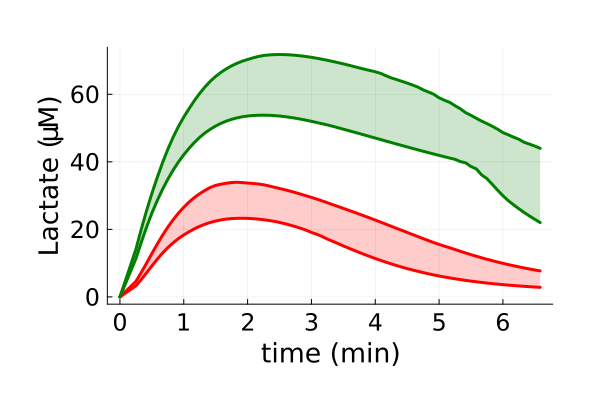

In [58]:
pr = plot(tsC2./60, PriorQuant1[1], label = "", color = "red", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant1[2], label = "", color = "red", linewidth = 3)
  plot!(tsC2./60, PriorQuant1[1], fillrange=PriorQuant1[2], label="", color="red", fillalpha=0.2)


  plot!(tsC2./60, PriorQuant2[1], label = "", color = "green", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant2[2], label = "", color = "green", linewidth = 3)
  plot!(tsC2./60, PriorQuant2[1], fillrange=PriorQuant2[2], label="", color="green", fillalpha=0.2)



In [60]:
Pyrs[inddis]

0.5

# OED Model Selection

In [61]:
function BhattacharyyaDist(mu1, mu2, sd1, sd2)
    
    E = (sd1+sd2)/2;
    Em1 = inv(E);
    dE = abs(det(E));
    
    t1 = mu1'-mu2';
    t2 = mu1-mu2;
    
    ft = (1/8)*t1*Em1*t2;
    st = dE/sqrt(abs(det(sd1))*abs(det(sd2)));
    
    bhd = ft+0.5*log(st);
    
    return(bhd);
    
end

BhattacharyyaDist (generic function with 1 method)

In [105]:
function Utility_OEDms(ins)

    Pyr = round(ins[1], digits = 1)*1000;
    smps = size(sampsTh_CR)[1]
    # Simulate the models for each theta and Y0 sampled
    # Competitivve Repression
    SimulsAll_CR = Array{Any}(undef, smps, 3);
    for i in 1:smps
        ivss = [Pyr, 0, 0, sampsY0_CR[i,1], sampsY0_CR[i,2], sampsY0_CR[i,3], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_CR[1,end]*0.12)];
        SimulsAll_CR[i,1], SimulsAll_CR[i,2], SimulsAll_CR[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(sampsTh_CR[i,:], 0), ivss, samps);
    end

    SimulsAll_AL = Array{Any}(undef, smps, 3);
    for i in 1:smps
        ivss = [Pyr, 0, 0, sampsY0_AL[i,1], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_AL[1,end]*0.12)];
        SimulsAll_AL[i,1], SimulsAll_AL[i,2], SimulsAll_AL[i,3]  = PyruvateHP_NMR_SolveAllAl(ts, vcat(sampsTh_AL[i,:], 0), ivss, samps);
    end

    # Define obervable matrix
    Obs_CR = zeros(length(samps)-1, smps)
    [Obs_CR[:,i]=SimulsAll_CR[1:smps,1][i][2:end,13,1] for i in 1:smps];

    Obs_AL = zeros(length(samps)-1, smps)
    [Obs_AL[:,i]=SimulsAll_AL[1:smps,1][i][2:end,11,1] for i in 1:smps];


    # Compute means and covariances
    muCR = mean!(ones(length(samps)-1), Obs_CR);
    sdCR = cov(transpose(Obs_CR)).+0.1*Matrix((Diagonal(ones(length(samps)-1))));

    muAL = mean!(ones(length(samps)-1), Obs_AL);
    sdAL = cov(transpose(Obs_AL)).+0.1*Matrix((Diagonal(ones(length(samps)-1))));

    bd = -BhattacharyyaDist(muCR, muAL, sdCR, sdAL)

    return(bd)

end

Utility_OEDms (generic function with 1 method)

In [87]:
Utility_OEDms(40) # 16 s

63.977890709961386

In [88]:
steps = 1;

In [89]:
model = ElasticGPE(steps,                            # 4*2 input dimensions
           mean = MeanConst(0.),
           kernel = SEArd(zeros(steps), 3.),
           logNoise = 0.,
           capacity = 3000);

In [90]:
modeloptimizer = MAPGPOptimizer(every = 50, noisebounds = [-4, 3],       # bounds of the logNoise
                               kernbounds = [[-1*ones(steps); 0], [4*ones(steps); 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                               maxeval = 50);

In [123]:
opt = BOpt(Utility_OEDms,
          model,
          ExpectedImprovement(),                   # type of acquisition            UpperConfidenceBound
          modeloptimizer,
          [0.1],[40.], # lowerbounds, upperbounds
          repetitions = 1,                          # evaluate the function for each input 1 times
          maxiterations = 80,                      # evaluate at 50 input positions
          sense = Min,  
                                      # maximise the function
          acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                restarts = 2,       # run the NLopt method from 5 random initial conditions each time.
                maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl
          verbosity = Progress);

In [124]:
result = boptimize!(opt) # 16 min

┌ Info: 2024-07-31T17:58:00.260	iteration: 5	current optimum: -67.03992062212097
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-07-31T17:58:09.619	iteration: 6	current optimum: -67.03992062212097
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-07-31T17:58:21.798	iteration: 7	current optimum: -67.03992062212097
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-07-31T17:58:35.896	iteration: 8	current optimum: -67.03992062212097
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-07-31T17:58:48.489	iteration: 9	current optimum: -67.03992062212097
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-07

(observed_optimum = -67.03992062212097, observed_optimizer = [0.7381652691330859], model_optimum = -57.5466968639477, model_optimizer = [40.0])

In [126]:
inputOED = result.observed_optimizer

1-element Vector{Float64}:
 0.7381652691330859

In [ ]:
inputOED = 0.7381652691330859;

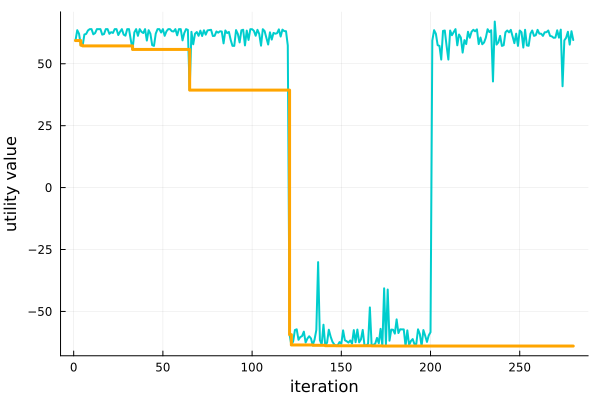

In [116]:
utilb = zeros(length(opt.model.y));
utilb[1] = opt.model.y[1];
for i in 2:length(opt.model.y)
    if opt.model.y[i]<=utilb[i-1]
        utilb[i] = opt.model.y[i];
    else
        utilb[i] = utilb[i-1];
    end
end

plot(opt.model.y, label = "", xlabel = "iteration", ylabel = "utility value", color="cyan3", linewidth = 2)
plot!(1:length(utilb), utilb, label = "", linetype=:step, color="orange", linewidth = 3)

### Save resutls

In [117]:
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CR_SeqOED_OED1_OEDmc.jld"), "result", result, "inputOED",inputOED)

In [118]:
optres = Dict("acquisitionoptions"=>opt.acquisitionoptions,
                "duration"=>opt.duration,
#                 "func"=>opt.func,
#                 "initializer"=>opt.initializer,
#                 "iterations"=>opt.iterations,
#                 "iterations"=>opt.iterations,
#                 "lowerbounds"=>opt.lowerbounds,
#                 "model"=>opt.model,
                "model_optimizer"=>opt.model_optimizer,
                "model_optimum"=>opt.model_optimum,
                "modeloptimizer"=>opt.modeloptimizer,
                "observed_optimizer"=>opt.observed_optimizer,
                "observed_optimum"=>opt.observed_optimum,
#                 "opt"=>opt.opt,
                "repetitions"=>opt.repetitions,
                "sense"=>opt.sense,
#                 "timeroutput"=>opt.timeroutput,
                "upperbounds"=>opt.upperbounds,
#                 "verbosity"=>opt.verbosity,
                "modelX"=>Array(opt.model.x),
                "modelY"=>Array(opt.model.y));
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CR_SeqOED_OED1_OEDmc2.jld"), optres)

## Plot Experiment

In [119]:
Pyr = round(inputOED[1], digits = 1)*1000;
smps = size(sampsTh_CR)[1]
# Simulate the models for each theta and Y0 sampled
# Competitivve Repression
SimulsOED_CR = Array{Any}(undef, smps, 3);
for i in 1:smps
    ivss = [Pyr, 0, 0, sampsY0_CR[i,1], sampsY0_CR[i,2], sampsY0_CR[i,3], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_CR[1,end]*0.12)];
    SimulsOED_CR[i,1], SimulsOED_CR[i,2], SimulsOED_CR[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(sampsTh_CR[i,:], 0), ivss, samps);
end

SimulsOED_AL = Array{Any}(undef, smps, 3);
for i in 1:smps
    ivss = [Pyr, 0, 0, sampsY0_AL[i,1], 0, 0, 0, 0, 0, Pyr, 0, Pyr*(sampsTh_AL[1,end]*0.12)];
    SimulsOED_AL[i,1], SimulsOED_AL[i,2], SimulsOED_AL[i,3]  = PyruvateHP_NMR_SolveAllAl(ts, vcat(sampsTh_AL[i,:], 0), ivss, samps);
end


In [120]:
tmp_sims = zeros(NSamps, 78)
tmp_sims2 = zeros(NSamps, 78)

for j in 1:NSamps
    tmp_sims[j,:] = SimulsOED_CR[:,1][j][:,11,1];
    tmp_sims2[j,:] = SimulsOED_AL[:,1][j][:,9,1];
end

In [121]:
# Dims = Up/Down, Observable, Experiment
PriorQuant1 = Array{Any}(undef,2,1,1);
PriorQuant2 = Array{Any}(undef,2,1,1);

for k in 1:1
    for m in 1:1
        PriorQuant1[1,k,m] = [percentile(tmp_sims[:,j], 99.5) for j in 1:size(tmp_sims)[2]]; # Up
        PriorQuant1[2,k,m] = [percentile(tmp_sims[:,j], 0.5 ) for j in 1:size(tmp_sims)[2]]; # Down

        PriorQuant2[1,k,m] = [percentile(tmp_sims2[:,j], 99.5) for j in 1:size(tmp_sims2)[2]]; # Up
        PriorQuant2[2,k,m] = [percentile(tmp_sims2[:,j], 0.5 ) for j in 1:size(tmp_sims2)[2]]; # Down
    end
end

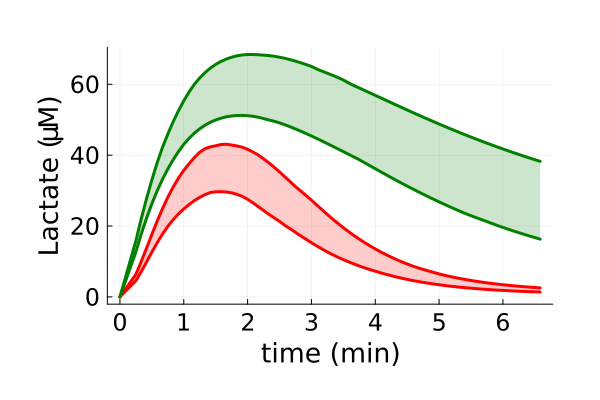

In [122]:
pr = plot(tsC2./60, PriorQuant1[1], label = "", color = "red", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant1[2], label = "", color = "red", linewidth = 3)
  plot!(tsC2./60, PriorQuant1[1], fillrange=PriorQuant1[2], label="", color="red", fillalpha=0.2)


  plot!(tsC2./60, PriorQuant2[1], label = "", color = "green", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = raw"Lactate (\muM)")
  plot!(tsC2./60, PriorQuant2[2], label = "", color = "green", linewidth = 3)
  plot!(tsC2./60, PriorQuant2[1], fillrange=PriorQuant2[2], label="", color="green", fillalpha=0.2)



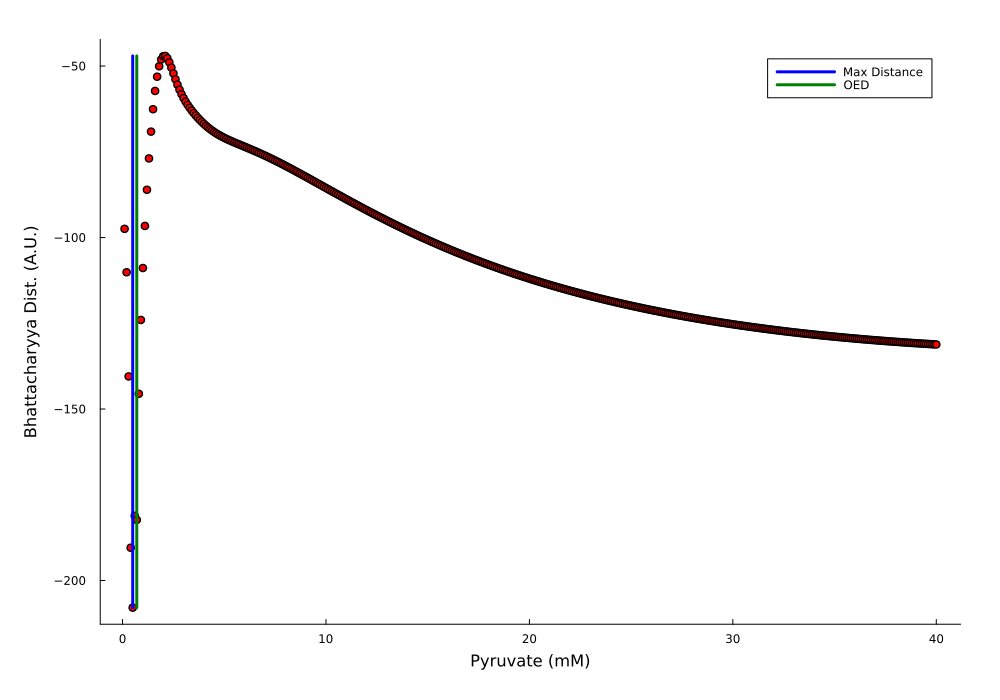

In [130]:
scatter(Pyrs, bd, label = "", grid=false, linewidth = 2, size = (1000,700), color = "red", 
        xlabel = "Pyruvate (mM)", ylabel = "Bhattacharyya Dist. (A.U.)", margin = 8mm)

plot!([Pyrs[findfirst(minimum(bd) .== bd)], Pyrs[findfirst(minimum(bd) .== bd)]],[minimum(bd), maximum(bd)], label = "Max Distance", linewidth=3, color = "blue")
plot!([round(inputOED[1], digits = 1), round(inputOED[1], digits = 1)],[minimum(bd), maximum(bd)], label = "OED", linewidth=3, color = "green")